Let's look at the case of a cylinder immersed in a flow

In [1]:
import gmsh
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm.autonotebook
from mpi4py import MPI
from petsc4py import PETSc
from basix.ufl import element
from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import (Constant, Function, functionspace,assemble_scalar, dirichletbc, form, locate_dofs_topological, set_bc)
from dolfinx.fem.petsc import (apply_lifting, assemble_matrix, assemble_vector,
                               create_vector, create_matrix, set_bc)
from dolfinx.graph import adjacencylist
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from dolfinx.io import (VTXWriter, distribute_entity_data, gmshio)
from dolfinx.mesh import create_mesh, meshtags_from_entities
from ufl import (FacetNormal, Identity, Measure, TestFunction, TrialFunction,
                 as_vector, div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym, system)

from tqdm.notebook import tqdm
from tqdm.autonotebook import tqdm

gmsh.initialize()  # Used to initialize the Gmsh working environment! It must be done before any other Gmsh call!!!!!
L = 2.2
H = 0.41
c_x = c_y = 0.2 # coordinates of the center of the cylinder
r = 0.05

gdim = 2
mesh_comm = MPI.COMM_WORLD
model_rank = 0
if mesh_comm.rank == model_rank:   # Used to ensure that the geometry is created on only one process (i.e., the one with rank=model_rank, usually 0)
# I add a rectangle and the obstacle in the OpenCASCADE CAD representation
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)
# The above two lines of code do not generate any mesh!!! They simply describe the domain geometrically

/var/folders/3y/fr3btx995jg2jh51k6k6wrm80000gn/T/ipykernel_49887/916972455.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook


In [2]:
# I then subtract the disk from the rectangular geometry
# so that we do not have to mesh the inside of the circle later

if mesh_comm.rank == model_rank:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])

    # Now that I have defined the domain geometrically, I synchronize it on all processes
    gmsh.model.occ.synchronize()
    # From now on, the geometry will be available to the Gmsh meshing engine!!!

- Now I define a marker (to tag) for the physical group (2D) of the fluid

(this will be needed later to "mesh" the fluid)

In [3]:
# To get GMSH to mesh the fluid, we add a physical volume marker

fluid_marker = 1
if mesh_comm.rank == model_rank:
    volumes = gmsh.model.getEntities(dim=gdim)
    # in this particular case: volumes=[(2,1)]
    # 2 is the dimension of the surface (because we are considering a rectangular domain "punctured" by the disk)
    # 1 is the tag of the entity (assigned directly by Gmsh)

    assert (len(volumes) == 1) # simply used to check that there is only one 2D geometric entity in the domain

    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker) # Define the physical group
    # volumes[0][0] <--- is equal to 2 (and indicates the dimension of the entity considered)
    # [volumes[0][1]] <-- is an array with a single element 1 (which will be the identifying tag of the entity)

    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid") # assign a name to the physical group!!!

Now I tag the various surfaces of the mesh, namely:

2) Inflow (x=0,y)
3) Outflow (x=L,y)
4) Fluid walls, i.e. the top (x,y=H) and bottom (x,y=0) boundaries
5) Obstacle walls (disk)

We will do this by computing the center of mass for each geometrical entity.

In [4]:
# define the various markers
inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []

if mesh_comm.rank == model_rank:
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    # boundaries will be a list of tuples (dim, tag) for each boundary of volumes
    
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
        # boundary[0]--> will be the dim of the boundary considered
        # boundary[1]--> will be the tag of the boundary considered
        # getCenterOfMass--> returns the coordinates (x,y,z) of the "center" of the boundary considered
        if np.allclose(center_of_mass, [0, H / 2, 0]):
            inflow.append(boundary[1]) # so I assign to "inflow" (created previously) the tag related to the corresponding boundary!
        elif np.allclose(center_of_mass, [L, H / 2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(center_of_mass, [L / 2, 0, 0]):
            walls.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    # thanks to this for loop, I was able to identify the various tags of the various boundaries of the 2D domain (volumes)


    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")

    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")

    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

In this problem, it is convenient to use an unstructured mesh!

In particular, given the nature of the problem, it is better to have a denser mesh near the obstacle!!
(and less dense far from it)

In [5]:
# Create distance field from obstacle.
# Add threshold of mesh sizes based on the distance field
# LcMax -                  /--------
#                      /
# LcMin -o---------/
#        |         |       |
#       Point    DistMin DistMax

res_min = r / 3   # r=0.05 is the radius of the disk
if mesh_comm.rank == model_rank:
    distance_field = gmsh.model.mesh.field.add("Distance") # I create a new mesh size field and assign it the fieldType: 'Distance'
    # distance_field will contain the tag of this new mesh size field
    
    gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)
    threshold_field = gmsh.model.mesh.field.add("Threshold")

    gmsh.model.mesh.field.setNumber(threshold_field, "IField", distance_field)
    gmsh.model.mesh.field.setNumber(threshold_field, "LcMin", res_min)
    gmsh.model.mesh.field.setNumber(threshold_field, "LcMax", 0.25 * H)
    gmsh.model.mesh.field.setNumber(threshold_field, "DistMin", r)
    gmsh.model.mesh.field.setNumber(threshold_field, "DistMax", 2 * H)
    min_field = gmsh.model.mesh.field.add("Min")
    gmsh.model.mesh.field.setNumbers(min_field, "FieldsList", [threshold_field])
    gmsh.model.mesh.field.setAsBackgroundMesh(min_field)

Let's now mesh
In this demo, to match the DFG 2D-3 benchmark, we use second order quadrilateral elements.

In [6]:
if mesh_comm.rank == model_rank:
    gmsh.option.setNumber("Mesh.Algorithm", 8)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)
    gmsh.option.setNumber("Mesh.RecombineAll", 1)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.setOrder(2)
    gmsh.model.mesh.optimize("Netgen")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 5 (Ellipse)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.00392783s, CPU 0.003941s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay for Quads)
Info    : Simple recombination completed (Wall 0.00162717s, CPU 0.001393s): 103 quads, 16 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.82361, min Q = 0.425555
Info    : Simple recombination completed (Wall 0.00242092s, CPU 0.002275s): 460 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.865979, min Q = 0.499255
Info    : Done meshing 2D (Wall 0.00774208s, CPU 0.006015s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 5 order 2
Info    : [ 20%] Meshing curve 6 order 2
Info    : [ 40%] Meshing curve 7 order 2
Info    : [ 60%] Mesh

As we have generated the mesh, we now need to load the mesh and corresponding facet markers into DOLFINx. 

In [7]:
mesh, _, ft = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
ft.name = "Facet markers"

DEFINITION OF THE VARIATIONAL PROBLEM

Now that the domain has been defined, I can specify the various parameters of the problem

In [8]:
t = 0
T = 8               # Final time (in realtà T=8; metto T=1 per questioni di tempi di calcolo)
dt = 1 / 1600                 # Time step size
num_steps = int(T / dt)
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(0.001))  # Dynamic viscosity
# mu = 0.001 ---> Re= 1000 !!!! (quando rho=1)
rho = Constant(mesh, PETSc.ScalarType(1))     # Density

In [9]:
from basix.ufl import element
from dolfinx.fem import functionspace

v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
V = functionspace(mesh, v_cg2) # vector space for the velocity u
Q = functionspace(mesh, s_cg1) # vector space for the pressure p
# Thus we are using continuous piecewise quadratic elements for the velocity and continuous piecewise linear elements for the pressure.

fdim = mesh.topology.dim - 1
# Define boundary conditions at the inlet (for the velocity)
class InletVelocity():
    def __init__(self, t):
        self.t = t
    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (0.41 - x[1]) / (0.41**2)
        return values


# Inlet (interpolate and apply the inlet BC)
u_inlet = Function(V)
inlet_velocity = InletVelocity(t)
u_inlet.interpolate(inlet_velocity)
bcu_inflow = dirichletbc(u_inlet, locate_dofs_topological(V, fdim, ft.find(inlet_marker)))

# Walls & Obstacle (apply the no_slip BC on the walls and on the obstacle)
u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bcu_walls = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V)
bcu_obstacle = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V)

# now I define the list containing the various BCs related to u
bcu = [bcu_inflow, bcu_obstacle, bcu_walls]

# Outlet (I define p=0 at the outlet!!)
bcp_outlet = dirichletbc(PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q)
bcp = [bcp_outlet]

VARIATIONAL FORMULA

Now that I have defined the domain (mesh) and BC, I can define my variational problem

In [10]:
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

u_ = Function(V) 
u_.name = "u"
u_s = Function(V)
u_n = Function(V)
u_n1 = Function(V)

p_ = Function(Q)
p_.name = "p"
phi = Function(Q)

Definisco quindi la formula variazionale per i 3 step per la risoluzione del problema

In [11]:
# Step 1
# calculation of a velocity that approximates u_n+1, i.e. u*:
f = Constant(mesh, PETSc.ScalarType((0, 0)))
F1 = rho / k * dot(u - u_n, v) * dx
F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
F1 += dot(f, v) * dx

a1 = form(lhs(F1))
L1 = form(rhs(F1))

A1 = create_matrix(a1)
b1 = create_vector(L1) 

In [12]:
# Step 2
# Calculation of the new pressure p
a2 = form(dot(grad(p), grad(q)) * dx)
L2 = form(-rho / k * dot(div(u_s), q) * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

In [13]:
# Step 3
# Calculation of the actual new velocity u_n+1
a3 = form(rho * dot(u, v) * dx)
L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

In [14]:
#Vado a definire i solver dei 3 step (e decidere le varie opzioni dei vari solver)

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.JACOBI)

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.MINRES)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

As a further verification of our implementation, we compute the drag (C_D) and lift coefficients (C_L) over the obstacle

In [15]:
n = -FacetNormal(mesh)  # Normal pointing out of obstacle
dObs = Measure("ds", domain=mesh, subdomain_data=ft, subdomain_id=obstacle_marker)
u_t = inner(as_vector((n[1], -n[0])), u_)
rho = Constant(mesh, PETSc.ScalarType(1))

drag = form(2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[1] - p_ * n[0]) * dObs)
lift = form(-2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[0] + p_ * n[1]) * dObs)
if mesh.comm.rank == 0:
    C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
    t_u = np.zeros(num_steps, dtype=np.float64)
    t_p = np.zeros(num_steps, dtype=np.float64)



We will also evaluate the pressure at two points, one in front of the obstacle (0.15, 0.2), and one behind the obstacle 
(0.25, 0.2).
 
To do this, we have to find which cell contains each of the points, so that we can create a linear combination of the local basis functions and coefficients.

In [16]:
tree = bb_tree(mesh, mesh.geometry.dim)
points = np.array([[0.15, 0.2, 0], [0.25, 0.2, 0]])
cell_candidates = compute_collisions_points(tree, points)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, points)
front_cells = colliding_cells.links(0)
back_cells = colliding_cells.links(1)
if mesh.comm.rank == 0:
    p_diff = np.zeros(num_steps, dtype=PETSc.ScalarType)

As we are solving a time dependent problem with many time steps, we use the tqdm-package to visualize the progress. 

In [17]:
from pathlib import Path

folder = Path("results_tutorial")
folder.mkdir(exist_ok=True, parents=True)
vtx_u = VTXWriter(mesh.comm, folder/"velocity_u.bp", [u_], engine="BP4")
vtx_p = VTXWriter(mesh.comm, folder/"pressure_p.bp", [p_], engine="BP4")
vtx_u.write(t)
vtx_p.write(t)
#progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)
progress = tqdm(desc="Solving PDE", total=num_steps)

for i in range(num_steps):
    progress.update(1)
    # Update current time step
    t += dt
    # Update inlet velocity
    inlet_velocity.t = t
    u_inlet.interpolate(inlet_velocity)

    # Step 1: Tentative velocity step
    A1.zeroEntries()
    assemble_matrix(A1, a1, bcs=bcu)
    A1.assemble()
    with b1.localForm() as loc:
        loc.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_s.x.petsc_vec)
    u_s.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc:
        loc.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, phi.x.petsc_vec)
    phi.x.scatter_forward()

    p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc:
        loc.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.x.petsc_vec)
    u_.x.scatter_forward()

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Update variable with solution form this time step
    with u_.x.petsc_vec.localForm() as loc_, u_n.x.petsc_vec.localForm() as loc_n, u_n1.x.petsc_vec.localForm() as loc_n1:
        loc_n.copy(loc_n1)
        loc_.copy(loc_n)

    # Compute physical quantities
    # For this to work in paralell, we gather contributions from all processors
    # to processor zero and sum the contributions.
    drag_coeff = mesh.comm.gather(assemble_scalar(drag), root=0)
    lift_coeff = mesh.comm.gather(assemble_scalar(lift), root=0)
    p_front = None
    
    if len(front_cells) > 0:
        p_front = p_.eval(points[0], front_cells[:1])
    p_front = mesh.comm.gather(p_front, root=0)
    p_back = None
    if len(back_cells) > 0:
        p_back = p_.eval(points[1], back_cells[:1])
    p_back = mesh.comm.gather(p_back, root=0)

    if mesh.comm.rank == 0:
        t_u[i] = t
        t_p[i] = t - dt / 2
        C_D[i] = sum(drag_coeff)
        C_L[i] = sum(lift_coeff)

        # Choose first pressure that is found from the different processors
        # and then calculate the delta_p!!!
        for pressure in p_front:
            if pressure is not None:
                p_diff[i] = pressure[0]
                break
        for pressure in p_back:
            if pressure is not None:
                p_diff[i] -= pressure[0]
                break
progress.close()
vtx_u.close()
vtx_p.close()

Solving PDE:   0%|          | 0/12800 [00:00<?, ?it/s]

I will evaluate the quality of the solution by comparing the calculated variables with data from FEATFLOW

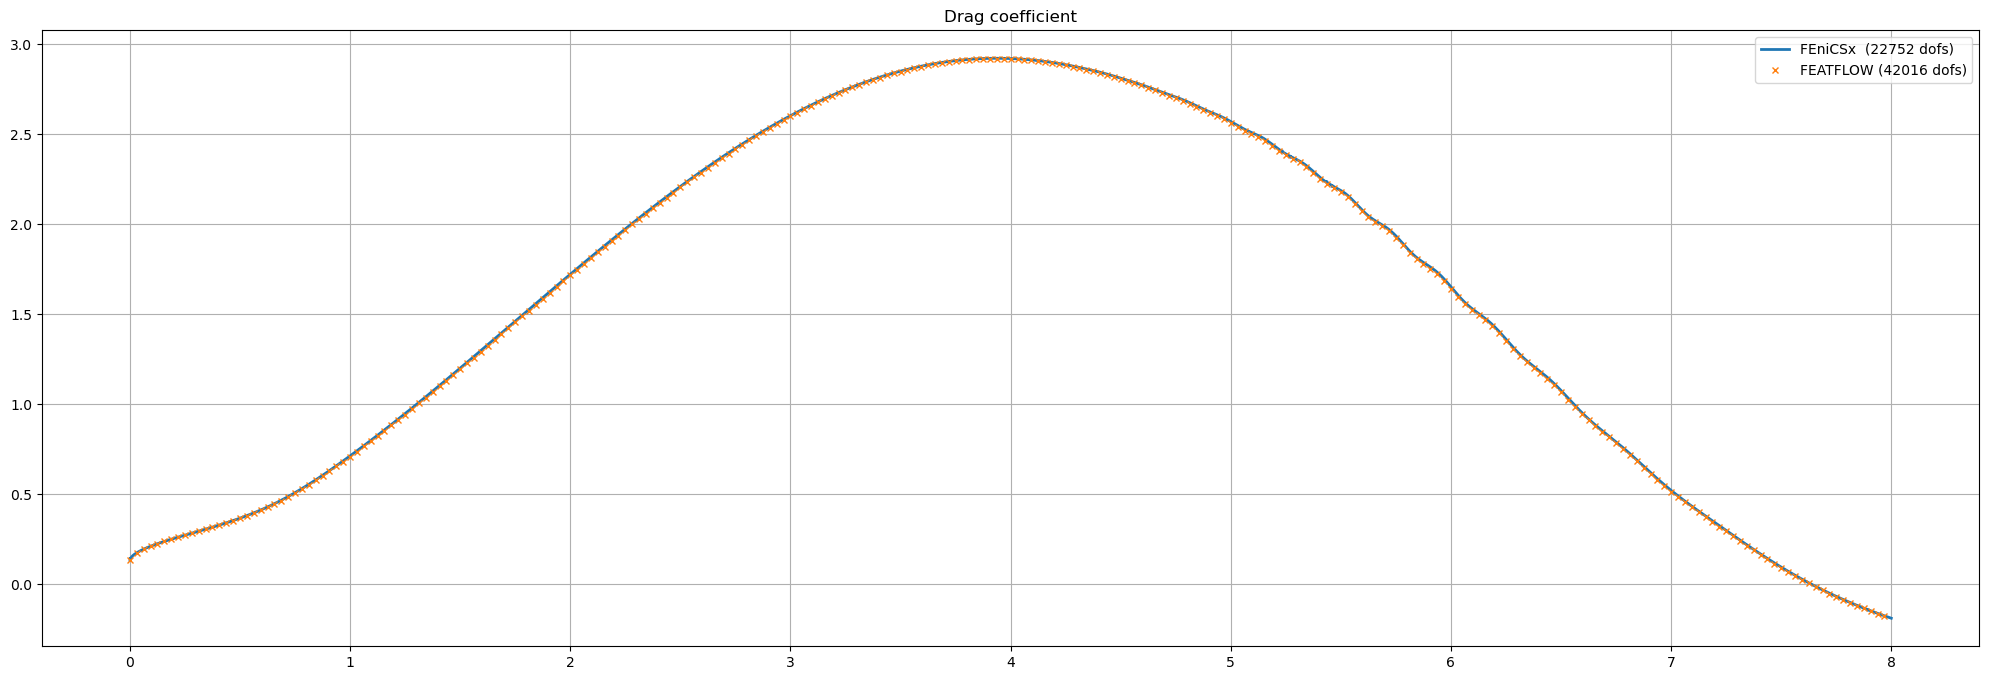

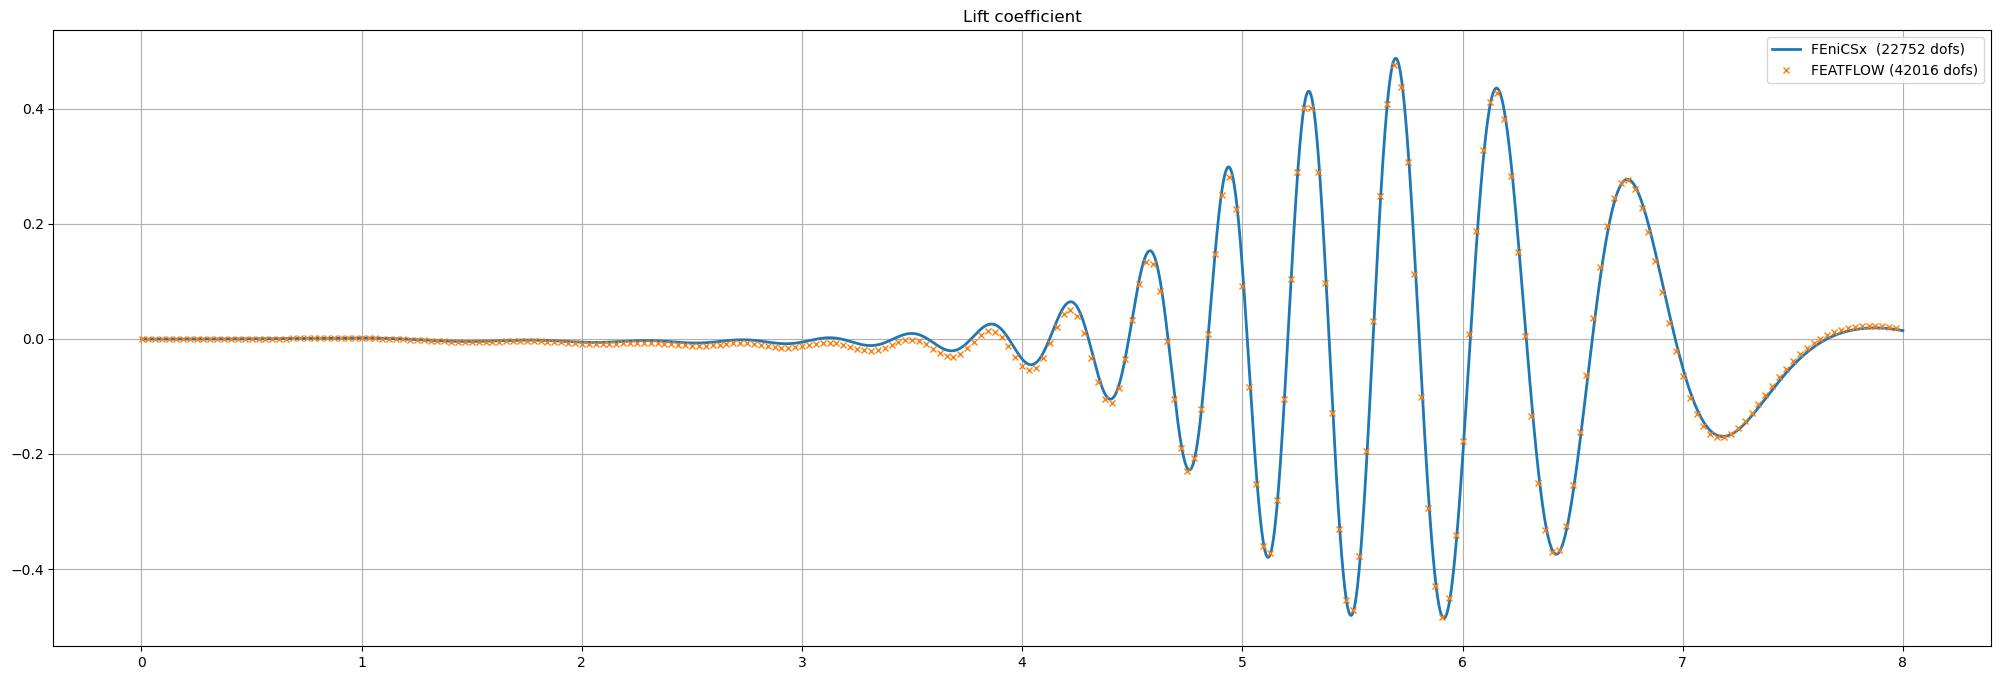

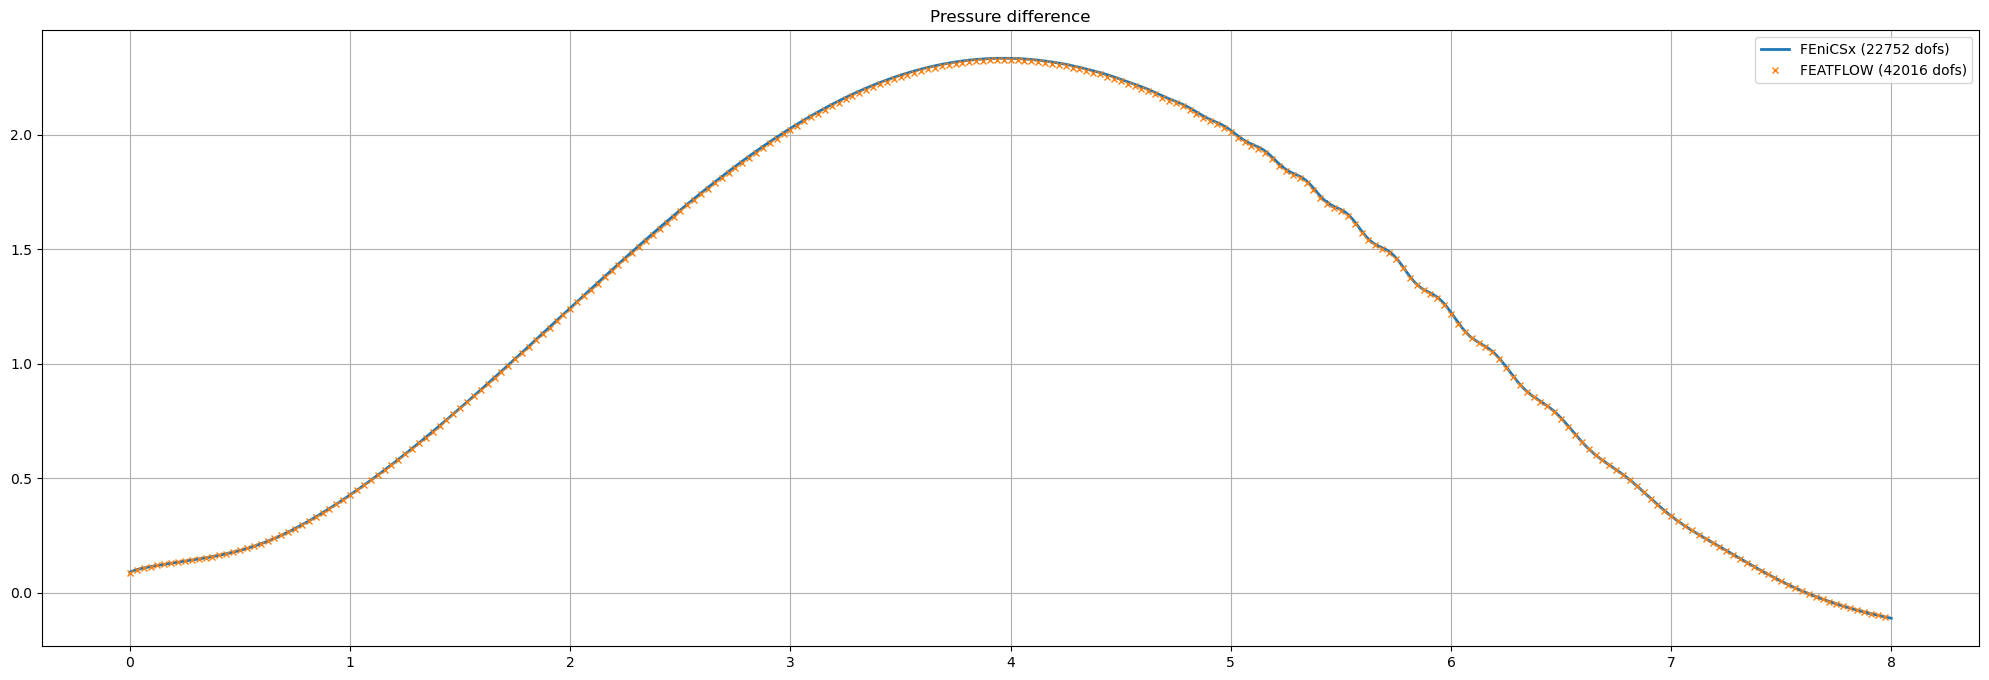

In [18]:
if mesh.comm.rank == 0:
    if not os.path.exists("figures"):
        os.mkdir("figures")
    num_velocity_dofs = V.dofmap.index_map_bs * V.dofmap.index_map.size_global
    num_pressure_dofs = Q.dofmap.index_map_bs * V.dofmap.index_map.size_global

    turek = np.loadtxt("bdforces_lv4")
    turek_p = np.loadtxt("pointvalues_lv4")
    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_u, C_D, label=r"FEniCSx  ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    l2 = plt.plot(turek[1:, 1], turek[1:, 3], marker="x", markevery=50,
                  linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Drag coefficient")
    plt.grid()
    plt.legend()
    plt.savefig("figures/drag_comparison.png")

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_u, C_L, label=r"FEniCSx  ({0:d} dofs)".format(
        num_velocity_dofs + num_pressure_dofs), linewidth=2)
    l2 = plt.plot(turek[1:, 1], turek[1:, 4], marker="x", markevery=50,
                  linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Lift coefficient")
    plt.grid()
    plt.legend()
    plt.savefig("figures/lift_comparison.png")

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_p, p_diff, label=r"FEniCSx ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    l2 = plt.plot(turek[1:, 1], turek_p[1:, 6] - turek_p[1:, -1], marker="x", markevery=50,
                  linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Pressure difference")
    plt.grid()
    plt.legend()
    plt.savefig("figures/pressure_comparison.png")